In [133]:
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

datasets = ["Caltech256","SUN397","CINIC10","CIFAR10","iWildCam","iWildCamOOD"]
test_dypes = ["InD","InD","InD","OOD","InD","OOD"]
nrow, ncol=2,3

cal_pred_in_prefix = "../Pred/cal_"
target_prefix = "../Pred/target_"

# cal_pred_in_prefix = "../Pred_minimum_loss/cal_"
# target_prefix = "../Pred_minimum_loss/target_"

unc_out_prefix = "csv/uncertainty_"
pred_out_prefix = "csv/pred_"

modelArch, modelS, modelM, modelL = "Resnets","Resnet18", "Resnet50", "Resnet101"

In [134]:
# TO BE DELETED:
# datasets = ["CIFAR10"]
# test_dypes = ["InD"]
# datasets = ["Caltech256","SUN397","CINIC10","CIFAR10"]
# test_dypes = ["InD","InD","InD","OOD"]
# nrow, ncol=2,2

## 1. Caculate Uncertainty Measures:

In [135]:
def soft_vote(pred_ls):
    sum_pred = np.sum(pred_ls,axis=0)
    return np.argmax(sum_pred,axis=1)

In [136]:
# generate Uncertainty Dataframes
for ds in datasets:
    dfS = pd.read_csv(f"{cal_pred_in_prefix}{ds}_{modelS}.csv")
    dfM = pd.read_csv(f"{cal_pred_in_prefix}{ds}_{modelM}.csv")
    dfL = pd.read_csv(f"{cal_pred_in_prefix}{ds}_{modelL}.csv")
    label = pd.read_csv(f"{target_prefix}{ds}.csv")
    prediction = pd.DataFrame({
    "pred_S": dfS.idxmax(axis=1),
    "pred_M": dfM.idxmax(axis=1),
    "pred_L": dfL.idxmax(axis=1),
    "target": label['target']
    })
    prediction["pred_S"] = prediction["pred_S"].str.extract('(\d+)').astype(int)
    prediction["pred_M"] = prediction["pred_M"].str.extract('(\d+)').astype(int)
    prediction["pred_L"] = prediction["pred_L"].str.extract('(\d+)').astype(int)
    prediction["softvote(S,M)"] = soft_vote([dfS,dfM])
    prediction["softvote(S,L)"] = soft_vote([dfS,dfL])
    prediction["softvote(M,L)"] = soft_vote([dfM,dfL])
    prediction["softvote(S,M,L)"] = soft_vote([dfS,dfM,dfL])
    prediction.to_csv(f"{pred_out_prefix}{ds}_{modelArch}.csv")
    unc = pd.DataFrame()
    unc["entr_S"] = utils.calc_entr_torch(dfS)
    unc["entr_M"] = utils.calc_entr_torch(dfM)
    unc["entr_L"] = utils.calc_entr_torch(dfL)
    unc["ce_S_M"] = utils.calc_cross_entr_torch(dfS,dfM)
    unc["ce_M_S"] = utils.calc_cross_entr_torch(dfM,dfS)
    unc["ce_S_L"] = utils.calc_cross_entr_torch(dfS,dfL)
    unc["ce_L_S"] = utils.calc_cross_entr_torch(dfL,dfS)
    unc["ce_M_L"] = utils.calc_cross_entr_torch(dfM,dfL)
    unc["ce_L_M"] = utils.calc_cross_entr_torch(dfL,dfM)
    # unc["entr_S"] = utils.calc_entropy_np(dfS)
    # unc["entr_M"] = utils.calc_entropy_np(dfM)
    # unc["entr_L"] = utils.calc_entropy_np(dfL)
    # unc["ce_S_M"] = utils.calc_cross_ent_np(dfS,dfM)
    # unc["ce_M_S"] = utils.calc_cross_ent_np(dfM,dfS)
    # unc["ce_S_L"] = utils.calc_cross_ent_np(dfS,dfL)
    # unc["ce_L_S"] = utils.calc_cross_ent_np(dfL,dfS)
    # unc["ce_M_L"] = utils.calc_cross_ent_np(dfM,dfL)
    # unc["ce_L_M"] = utils.calc_cross_ent_np(dfL,dfM)
    unc["entr_S+entr_M"] = unc["entr_S"]+unc["entr_M"]
    unc["zs_entr_S+zs_entr_M"] = zscore(unc["entr_S"])+zscore(unc["entr_M"])
    unc["entr_M+ce_M_S"] = unc["entr_M"]+unc["ce_M_S"]
    unc["zs_entr_M+zs_ce_M_S"] = zscore(unc["entr_M"])+zscore(unc["ce_M_S"])
    unc["entr_L+ce_L_S"] = unc["entr_L"]+unc["ce_L_S"]
    unc.to_csv(f"{unc_out_prefix}{ds}_{modelArch}.csv")

In [137]:
display(prediction.head(2))
display(unc.head(2))

,pred_S,pred_M,pred_L,target,"softvote(S,M)","softvote(S,L)","softvote(M,L)","softvote(S,M,L)"
0,0,0,0,113,0,0,0,0
1,0,0,0,113,0,0,0,0


,entr_S,entr_M,entr_L,ce_S_M,ce_M_S,ce_S_L,ce_L_S,ce_M_L,ce_L_M,entr_S+entr_M,zs_entr_S+zs_entr_M,entr_M+ce_M_S,zs_entr_M+zs_ce_M_S,entr_L+ce_L_S
0,0.486723,1.520978,0.587726,0.734404,2.029601,0.578835,0.664460,1.898405,0.765760,2.007701,-0.438013,3.550579,0.778558,1.252186
1,0.487744,1.114227,0.916906,0.668062,1.502196,0.641510,1.185252,1.226797,0.987468,1.601971,-0.917266,2.616423,-0.144391,2.102158


# 2. Test Accuracy

In [138]:
def eval_pred(pred):
    results = []
    for col in pred.columns.drop("target"):
        acc = (pred[col] == pred["target"]).mean()
        results.append({"Method": col, "Accuracy": acc})
    return pd.DataFrame(results)
def barplot_acc(pred, ds, ax, margin = 0.02):
    results_df = eval_pred(pred)
    sns.barplot(x='Method', y='Accuracy', data=results_df, ax=ax)
    pred_S_acc = results_df.loc[results_df['Method'] == 'pred_S', 'Accuracy'].values[0]
    pred_M_acc = results_df.loc[results_df['Method'] == 'pred_M', 'Accuracy'].values[0]
    pred_L_acc = results_df.loc[results_df['Method'] == 'pred_L', 'Accuracy'].values[0]
    baseline_acc = max(pred_M_acc, pred_S_acc, pred_L_acc)
    baseline_method = 'predS' if baseline_acc == pred_S_acc else 'predM' if baseline_acc == pred_M_acc  else 'predL'
    ax.axhline(y=baseline_acc, color='r', linestyle='--')
    ax.text(0, baseline_acc, f"Baseline ({baseline_method}): {baseline_acc:.2%}", color='r', ha='center', va='bottom')
    
    for index, row in results_df.iterrows():
        ax.text(index, row['Accuracy'], f"{row['Accuracy']:.2%}", color='black', ha="center")
    
    ax.tick_params(axis='x', rotation=45)
    ax.set_title(f'Ensemble Accuracy on {ds}')
    ax.set_xlabel('Ensembling Method')
    ax.set_ylabel('Accuracy')
    
    min_acc = results_df['Accuracy'].min()
    max_acc = results_df['Accuracy'].max()
    ax.set_ylim(min_acc - margin, min(1, max_acc + margin))

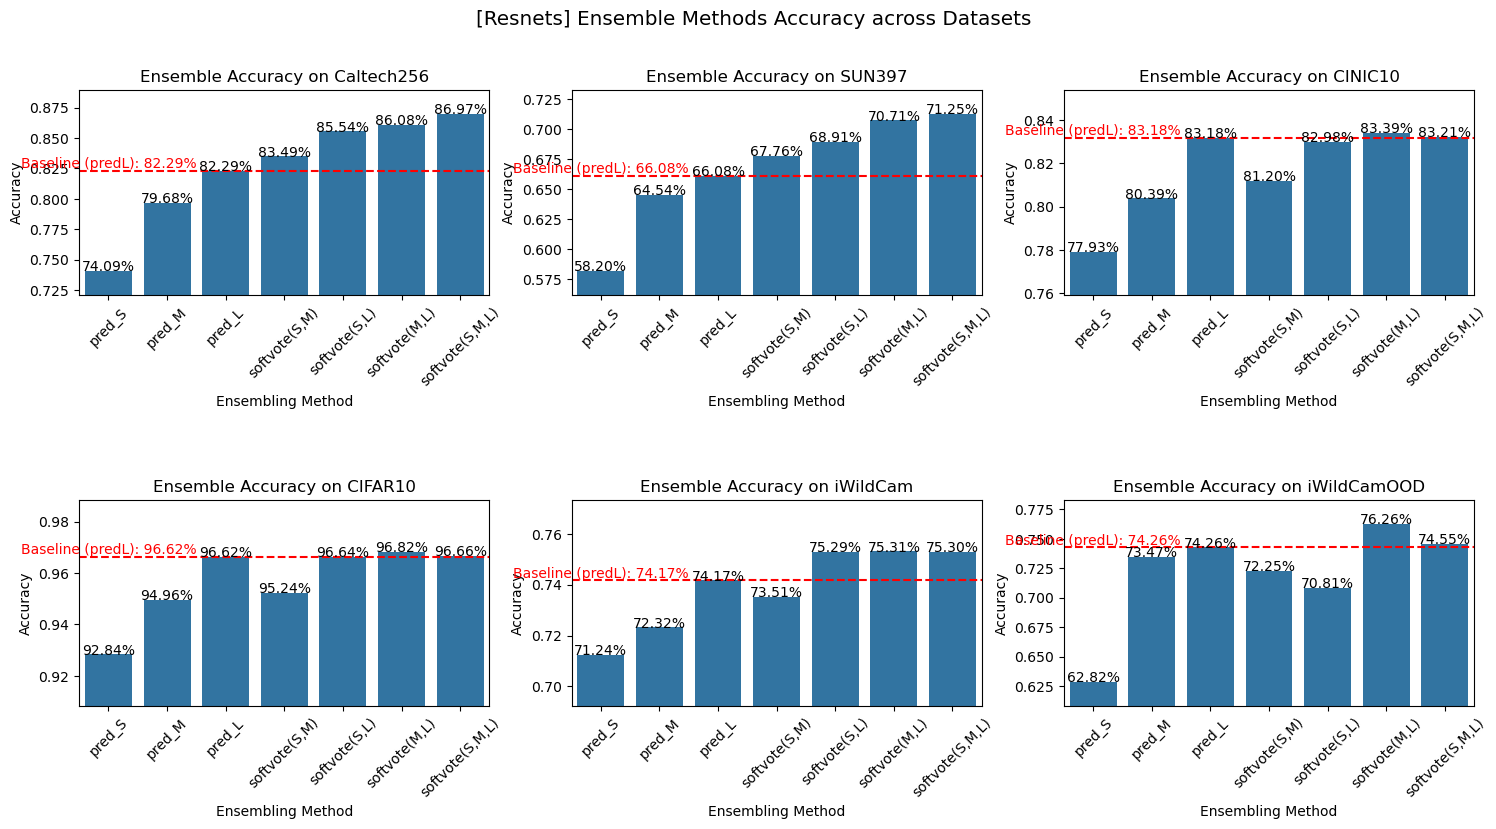

In [139]:
fig, axes = plt.subplots(nrow, ncol, figsize=(6*ncol, 4*nrow))

for i, ds in enumerate(datasets):
    pred = pd.read_csv(f"{pred_out_prefix}{ds}_{modelArch}.csv", index_col="Unnamed: 0")
    unc_pred = pd.read_csv(f"{unc_out_prefix}{ds}_{modelArch}.csv", index_col="Unnamed: 0")
    ax = axes[i // ncol, i % ncol]
    barplot_acc(pred,ds,ax)
plt.subplots_adjust(hspace=1)
plt.suptitle(f"[{modelArch}] Ensemble Methods Accuracy across Datasets",fontsize = 'x-large')
plt.show()

# 3. AUROC

In [140]:
import sklearn.metrics as metrics
def auroc(pred_df, unc_df, pred_vec, target_vec, unc_vec, ax):
    label = f"{unc_vec} on {pred_vec}"
    fpr, tpr, threshold = metrics.roc_curve(pred_df[pred_vec]!=pred_df[target_vec], unc_df[unc_vec])
    roc_auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, label = f'{label}: AUC = %0.3f' % roc_auc)
    ax.legend(loc = 'lower right')
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

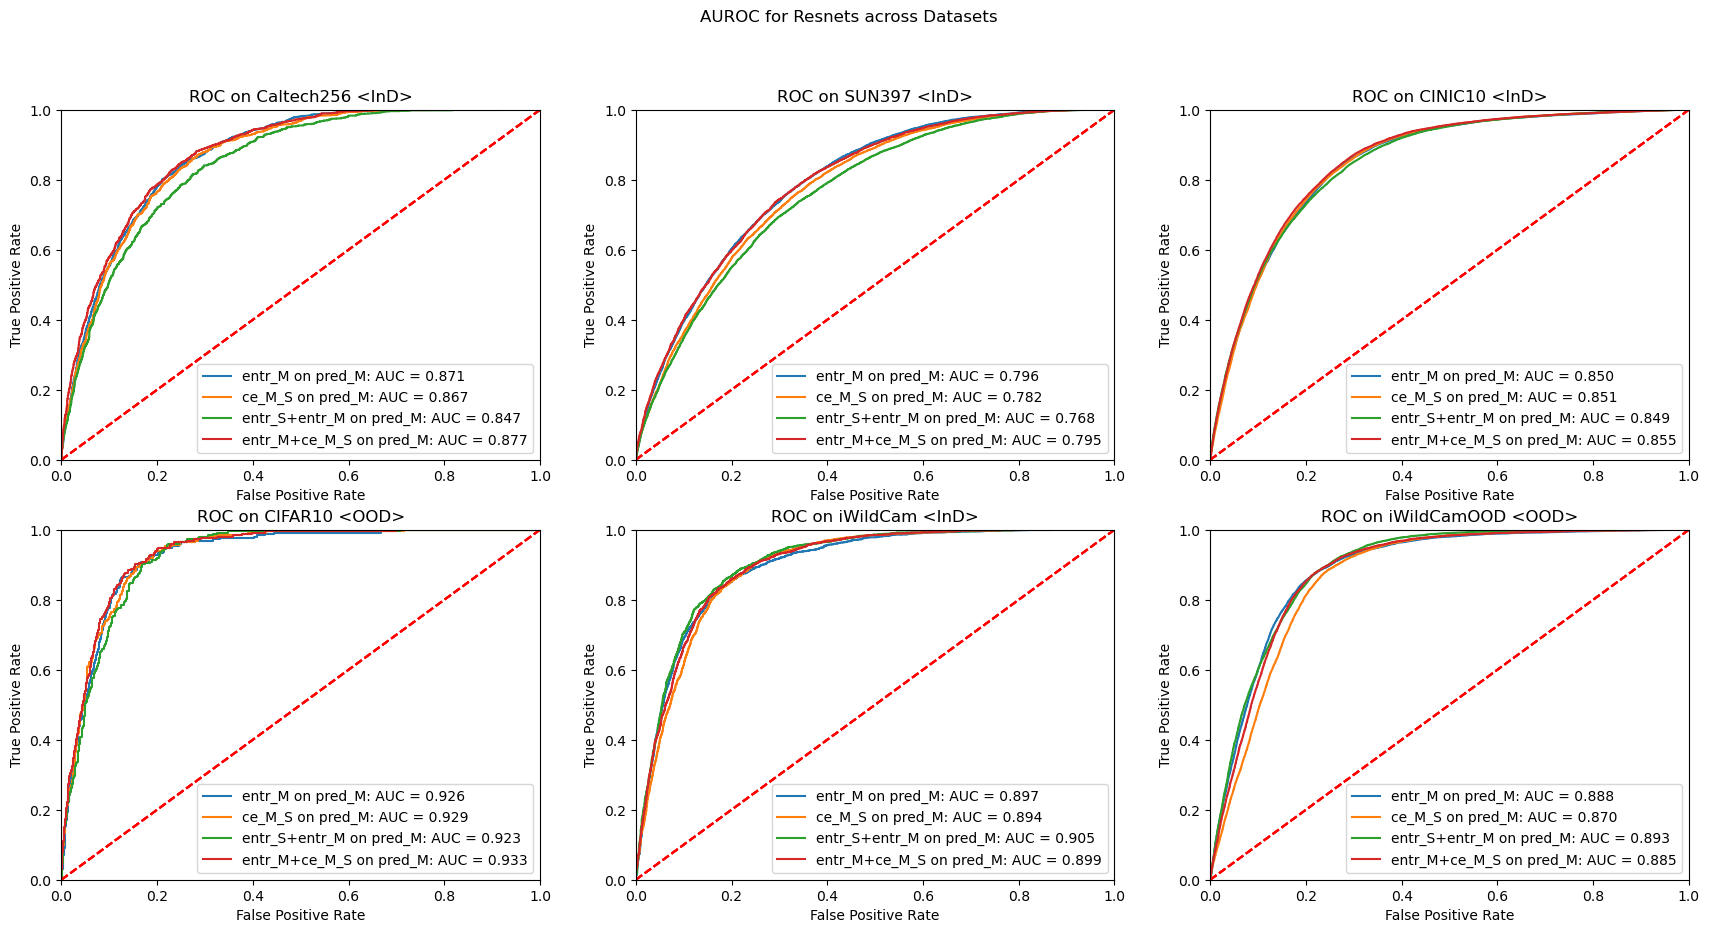

In [141]:
fig, axes = plt.subplots(nrow, ncol, figsize=(7*ncol, 5*nrow))
for i, ds in enumerate(datasets):
    pred_df = pd.read_csv(f"{pred_out_prefix}{ds}_{modelArch}.csv", index_col="Unnamed: 0")
    unc_df = pd.read_csv(f"{unc_out_prefix}{ds}_{modelArch}.csv", index_col="Unnamed: 0")
    ax = axes[i // ncol, i % ncol]
    ax.set_title(f"ROC on {ds} <{test_dypes[i]}>")
    # auroc(pred_df, unc_df, "pred_S", "target", "entr_S", ax)
    auroc(pred_df, unc_df, "pred_M", "target", "entr_M", ax)
    auroc(pred_df, unc_df, "pred_M", "target", "ce_M_S", ax)
    auroc(pred_df, unc_df, "pred_M", "target", "entr_S+entr_M", ax)
    # auroc(pred_df, unc_df, "pred_M", "target", "zs_entr_S+zs_entr_M", ax)
    auroc(pred_df, unc_df, "pred_M", "target", "entr_M+ce_M_S", ax)
    # auroc(pred_df, unc_df, "pred_M", "target", "zs_entr_M+zs_ce_M_S", ax)
    # auroc(pred_df, unc_df, "pred_L", "target", "entr_L", ax)
    # auroc(pred_df, unc_df, "softvote(S,M)", "target", "entr_S", ax)
    # auroc(pred_df, unc_df, "softvote(S,M)", "target", "entr_M", ax)
    # auroc(pred_df, unc_df, "softvote(S,M)", "target", "entr_S+entr_M", ax)
    # auroc(pred_df, unc_df, "softvote(S,M)", "target", "zs_entr_S+zs_entr_M", ax)
    # auroc(pred_df, unc_df, "softvote(S,M)", "target", "ce_M_S", ax)
    # auroc(pred_df, unc_df, "softvote(S,M)", "target", "entr_M+ce_M_S", ax)
    # auroc(pred_df, unc_df, "softvote(S,M)", "target", "zs_entr_M+zs_ce_M_S", ax)
plt.suptitle(f"AUROC for {modelArch} across Datasets")
plt.show()

In [123]:
def weighted_sum_of_entropy(p, unc_df, entr1_col, entr2_col, pred_df, pred_col, target_col, zs=False):
    if(zs):
        fpr, tpr, threshold = metrics.roc_curve(pred_df[pred_col]!=pred_df[target_col], p*zscore(unc_df[entr1_col])+(1-p)*zscore(unc_df[entr2_col]))
    else:
        fpr, tpr, threshold = metrics.roc_curve(pred_df[pred_col]!=pred_df[target_col], p*unc_df[entr1_col]+(1-p)*unc_df[entr2_col])
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc
def explore_weighted_sum(n, unc_df, entr1_col, entr2_col, pred_df, pred_col, target_col, ax):
    p_ls = np.arange(n)/(n-1)
    auroc_ls = np.zeros(n)
    # auroc_zs_ls = np.zeros(n)
    for i,p in enumerate(p_ls):
        auroc_ls[i]=weighted_sum_of_entropy(p, unc_df, entr1_col, entr2_col, pred_df, pred_col, target_col, False)
        # auroc_zs_ls[i]=weighted_sum_of_entropy(p, unc_df, entr1_col, entr2_col, pred_df, pred_col, target_col, True)
    temp_max = auroc_ls.max()
    temp_argmax = auroc_ls.argmax()
    # temp_max_zs = auroc_zs_ls.max()
    sns.lineplot(x=p_ls,y=auroc_ls, label=f"max={temp_max:.3f}: {entr1_col} and {entr2_col} on {pred_col}", ax=ax)
    # sns.lineplot(x=p_ls,y=auroc_zs_ls, label=f"max={temp_max_zs:.3f}: zs {entr1_col} and {entr2_col} on {pred_col}", ax=ax)
    ax.set_ylabel('AUROC')
    ax.set_xlabel('p (weight to first unc measure)')
    return p_ls[temp_argmax]

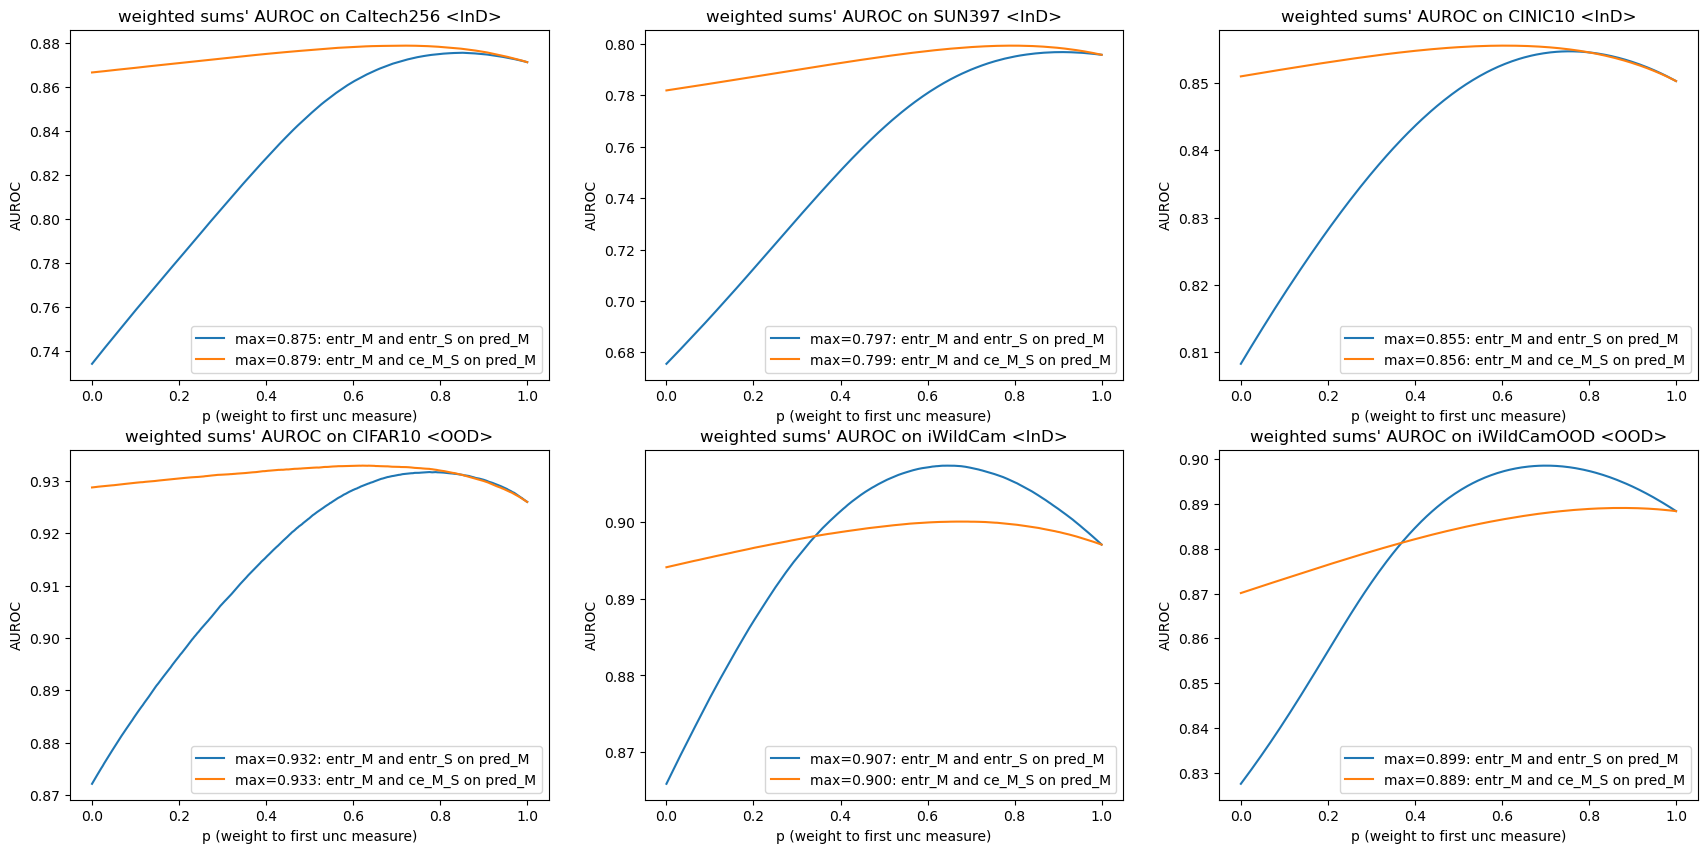

In [142]:
fig, axes = plt.subplots(nrow, ncol, figsize=(7*ncol, 5*nrow))
nsteps=500
for i, ds in enumerate(datasets):
    pred_df = pd.read_csv(f"{pred_out_prefix}{ds}_{modelArch}.csv", index_col="Unnamed: 0")
    unc_df = pd.read_csv(f"{unc_out_prefix}{ds}_{modelArch}.csv", index_col="Unnamed: 0")
    ax = axes[i // ncol, i % ncol]
    ax.set_title(f"weighted sums' AUROC on {ds} <{test_dypes[i]}>")
    opt_p_predM = explore_weighted_sum(nsteps, unc_df, "entr_M","entr_S",pred_df,"pred_M","target",ax)
    unc_df["opt_entr_M_plus_entr_S_for_pred_M"] = opt_p_predM*unc_df['entr_M']+(1-opt_p_predM)*unc_df["entr_S"]
    # explore_weighted_sum(nsteps, unc_df, "opt_entr_M_plus_entr_S_for_pred_M","ce_M_S",pred_df,"pred_M","target",ax)
    opt_p_entr_ce_pred_M = explore_weighted_sum(nsteps, unc_df, "entr_M","ce_M_S",pred_df,"pred_M","target",ax)
    unc_df["opt_entr_M_plus_ce_M_S_for_pred_M"] = opt_p_entr_ce_pred_M*unc_df['entr_M']+(1-opt_p_entr_ce_pred_M)*unc_df["ce_M_S"]
    # explore_weighted_sum(nsteps, unc_df, "opt_entr_M_plus_ce_M_S_for_pred_M","entr_S",pred_df,"pred_M","target",ax)
    
    # opt_p_sv = explore_weighted_sum(nsteps, unc_df, "entr_M","entr_S",pred_df,"softvote(S,M)","target",ax)
    # unc_df["opt_entr(S)+entr(M)_for_sv(S,M)"] = opt_p_sv*unc_df['entr_M']+(1-opt_p_sv)*unc_df["entr_S"]
    
    # opt_p_entr_ce_sv = explore_weighted_sum(nsteps, unc_df, "entr_M","ce_M_S",pred_df,"softvote(S,M)","target",ax)
    # unc_df["opt_entr_S_plus_ce_M_S_for_sv(S,M)"] = opt_p_entr_ce_sv*unc_df['entr_M']+(1-opt_p_entr_ce_sv)*unc_df["ce_M_S"]
    # explore_weighted_sum(nsteps, unc_df, "entr_M","ce_M_S",pred_df,"softvote(S,M)","target",ax)
    # explore_weighted_sum(nsteps, unc_df, "opt_entr(S)+entr(M)_for_sv(S,M)","ce_M_S",pred_df,"softvote(S,M)","target",ax)
    unc_df.to_csv(f"{unc_out_prefix}{ds}_{modelArch}.csv")
plt.show()

In [125]:
# fig, axes = plt.subplots(nrow, ncol, figsize=(7*ncol, 5*nrow))
# nsteps=200
# for i, ds in enumerate(datasets):
#     pred_df = pd.read_csv(f"{pred_out_prefix}{ds}_{modelArch}.csv", index_col="Unnamed: 0")
#     unc_df = pd.read_csv(f"{unc_out_prefix}{ds}_{modelArch}.csv", index_col="Unnamed: 0")
#     ax = axes[i // ncol, i % ncol]
#     ax.set_title(f"weighted sums' AUROC on {ds} <{test_dypes[i]}>")
#     # explore_weighted_sum(nsteps, unc_df, "entr_L","entr_S",pred_df,"pred_L","target",ax)
#     # explore_weighted_sum(nsteps, unc_df, "entr_L","ce_L_S",pred_df,"pred_L","target",ax)
#     opt_p=explore_weighted_sum(nsteps, unc_df, "entr_L","entr_M",pred_df,"softvote(M,L)","target",ax)
#     explore_weighted_sum(nsteps, unc_df, "entr_L","ce_L_M",pred_df,"softvote(M,L)","target",ax)
#     unc_df["opt_entr_sum_M_S"] = opt_p*unc_df['entr_M']+(1-opt_p)*unc_df["entr_S"]

In [126]:
from scipy import stats

results_list = []

# Loop through the datasets and calculate Spearman correlations
for ds in datasets:
    pred = pd.read_csv(f"{pred_out_prefix}{ds}_{modelArch}.csv", index_col="Unnamed: 0")
    unc_pred = pd.read_csv(f"{unc_out_prefix}{ds}_{modelArch}.csv", index_col="Unnamed: 0")
    # display(unc_pred.head(1))
    # Calculate Spearman correlations
    sm_eS_eM = stats.spearmanr(unc_pred["entr_S"], unc_pred["entr_M"]).statistic
    sm_eS_eL = stats.spearmanr(unc_pred["entr_S"], unc_pred["entr_L"]).statistic
    sm_eM_eL = stats.spearmanr(unc_pred["entr_M"], unc_pred["entr_L"]).statistic
    sm_eM_ce_M_S = stats.spearmanr(unc_pred["entr_M"], unc_pred["ce_M_S"]).statistic
    sm_eM_eM_pl_ce_M_S = stats.spearmanr(unc_pred["entr_M"], unc_pred["entr_M+ce_M_S"]).statistic
    
    opt_p_predM = explore_weighted_sum(nsteps, unc_pred, "entr_M","entr_S",pred,"pred_M","target",ax)
    unc_pred["opt_entr_sum_M_S_for_pred_M"] = opt_p_predM*unc_pred['entr_M']+(1-opt_p_predM)*unc_pred["entr_S"]
    sm_eM_eS = stats.spearmanr(unc_pred["entr_M"], unc_pred["entr_S+entr_M"]).statistic
    sm_opt_eM_eS_forpredM = stats.spearmanr(unc_pred["entr_M"], unc_pred["opt_entr_sum_M_S_for_pred_M"]).statistic
    
    opt_p_sv = explore_weighted_sum(nsteps, unc_pred, "entr_M","entr_S",pred,"softvote(S,M)","target",ax)
    unc_pred["opt_entr_sum_M_S_for_sv"] = opt_p_sv*unc_pred['entr_M']+(1-opt_p_sv)*unc_pred["entr_S"]
    sm_opt_eM_eS_forsv = stats.spearmanr(unc_pred["entr_M"], unc_pred["opt_entr_sum_M_S_for_sv"]).statistic
    # Store results in a dictionary
    results_dict = {
        "Dataset": ds,
        "SRC(entrS,entrM)": sm_eS_eM,
        "SRC(entrS,entrL)": sm_eS_eL,
        "SRC(entrM,entrL)": sm_eM_eL,
        "SRC(entrM,ceMS)": sm_eM_ce_M_S,
        "SRC(entrM,entrM+ceMS)": sm_eM_eM_pl_ce_M_S,
        "SRC(entrM,entrS+entrM)": sm_eM_eS,
        "[opt for predM]SRC(entrM,entrS+entrM)": sm_opt_eM_eS_forpredM,
        "[opt for softVote]SRC(entrM,entrS+entrM)": sm_opt_eM_eS_forsv,
    }
    
    # Append the results dictionary to the list
    results_list.append(results_dict)

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results_list)

# Display the results DataFrame
display(results_df)

,Dataset,"SRC(entrS,entrM)","SRC(entrS,entrL)","SRC(entrM,entrL)","SRC(entrM,ceMS)","SRC(entrM,entrM+ceMS)","SRC(entrM,entrS+entrM)","[opt for predM]SRC(entrM,entrS+entrM)","[opt for softVote]SRC(entrM,entrS+entrM)"
0,Caltech256,0.499459,0.489504,0.560662,0.843914,0.904227,0.785554,0.971415,0.902622
1,SUN397,0.510021,0.502023,0.585186,0.841063,0.915652,0.833511,0.992459,0.963676
2,CINIC10,0.759843,0.714983,0.794819,0.942733,0.966176,0.920179,0.969730,0.960584
3,CIFAR10,0.726319,0.634592,0.734398,0.948362,0.967161,0.885132,0.951906,0.941648
4,iWildCam,0.788397,0.766139,0.831915,0.952043,0.975208,0.934447,0.967620,0.955402
5,iWildCamOOD,0.715504,0.778689,0.821866,0.900507,0.941254,0.894357,0.956824,0.956456


# Accuracy Coverage Trade-off

In [127]:
def get_rank(unc_pred):
    rank = pd.DataFrame()
    for curr_metric in unc_pred.columns:
        rank[curr_metric] = unc_pred[curr_metric].rank()
    return rank

def acc_cov_tradeoff(pred_df, pred_vec, target_vec, unc_vec, rank, ax, cov_range):
    temp=pd.DataFrame()
    temp["coverage"] = cov_range
    coverage_ls = (cov_range+1)/100*pred.shape[0]
    for i, cov in enumerate(coverage_ls):
        cov_pred = pred_df[rank[unc_vec]<cov]
        temp.loc[i,"acc"] = np.mean(cov_pred[pred_vec]==cov_pred[target_vec])
    area=np.sum(temp["acc"])
    label = f"(AUC: {area:.3f}) - {unc_vec} on {pred_vec}"
    sns.lineplot(temp,x="coverage",y="acc",label=label,ax = ax)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Coverage')
    ax.legend(loc = 'lower right')
    

### ACC-COV tradeoff on PredM

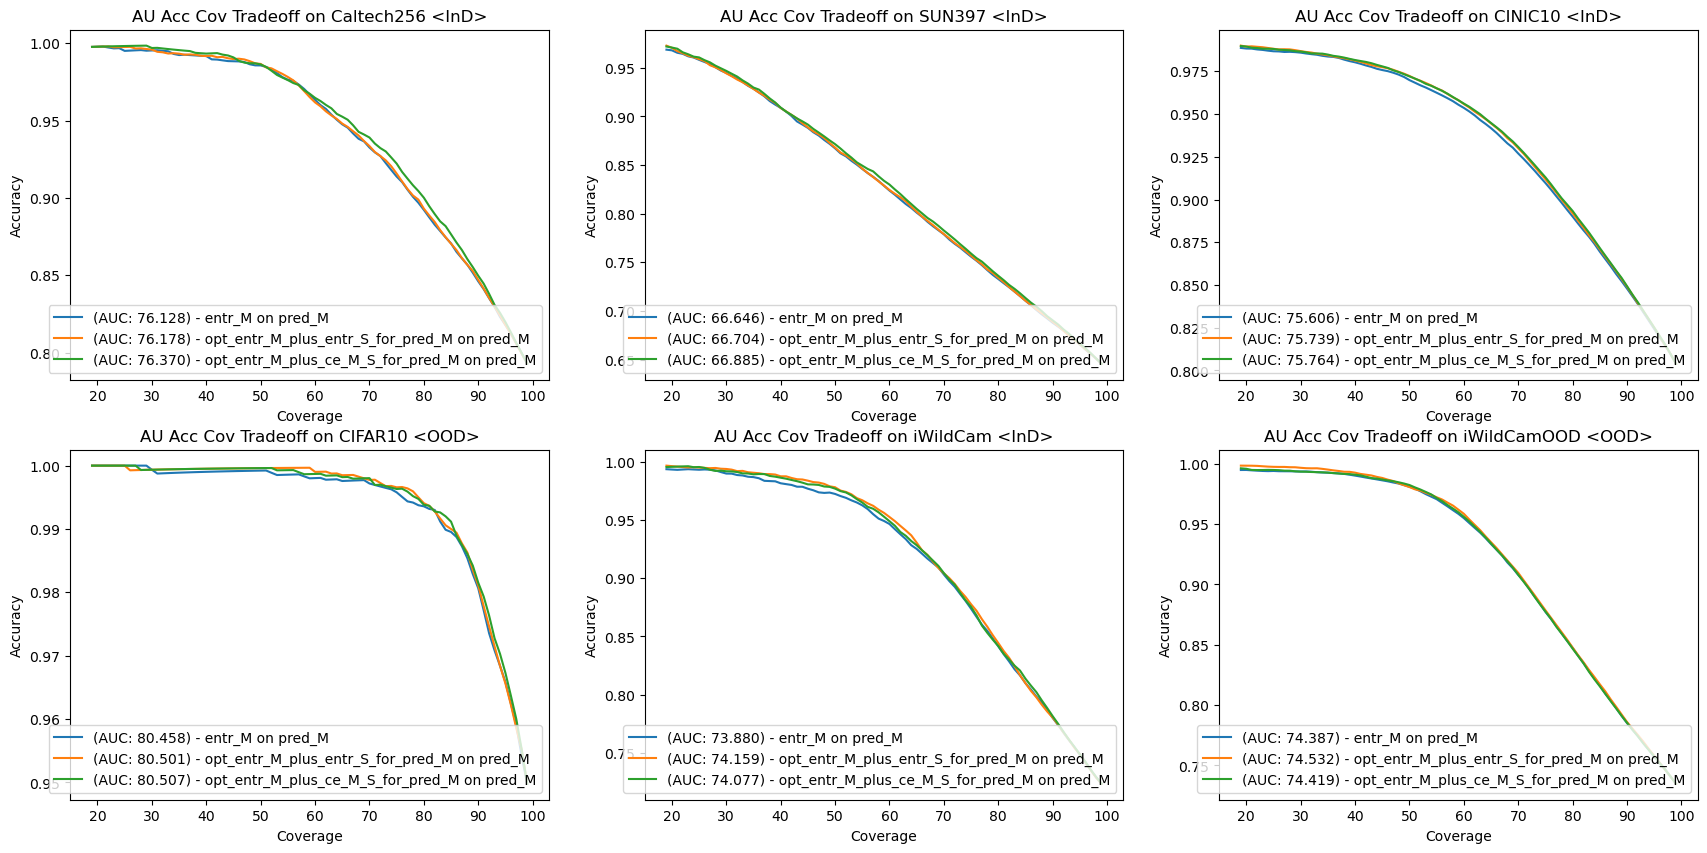

In [131]:
cov_range = np.arange(19,100)
fig, axes = plt.subplots(nrow, ncol, figsize=(7*ncol, 5*nrow))
for i, ds in enumerate(datasets):
    ax = axes[i // ncol, i % ncol]
    ax.set_title(f"AU Acc Cov Tradeoff on {ds} <{test_dypes[i]}>")
    pred = pd.read_csv(f"{pred_out_prefix}{ds}_{modelArch}.csv", index_col="Unnamed: 0")
    unc_pred = pd.read_csv(f"{unc_out_prefix}{ds}_{modelArch}.csv", index_col="Unnamed: 0")
    rank=get_rank(unc_pred)
    acc_cov_tradeoff(pred, "pred_M", "target", "entr_M", rank, ax, cov_range)
    # acc_cov_tradeoff(pred, "pred_M", "target", "ce_M_S", rank, ax, cov_range)
    # acc_cov_tradeoff(pred, "pred_M", "target", "entr_S+entr_M", rank, ax, cov_range)
    # acc_cov_tradeoff(pred, "pred_M", "target", "entr_M+ce_M_S", rank, ax, cov_range)
    acc_cov_tradeoff(pred, "pred_M", "target", "opt_entr_M_plus_entr_S_for_pred_M", rank, ax, cov_range)
    acc_cov_tradeoff(pred, "pred_M", "target", "opt_entr_M_plus_ce_M_S_for_pred_M", rank, ax, cov_range)

### ACC-COV tradeoff on SoftVote(S,M)

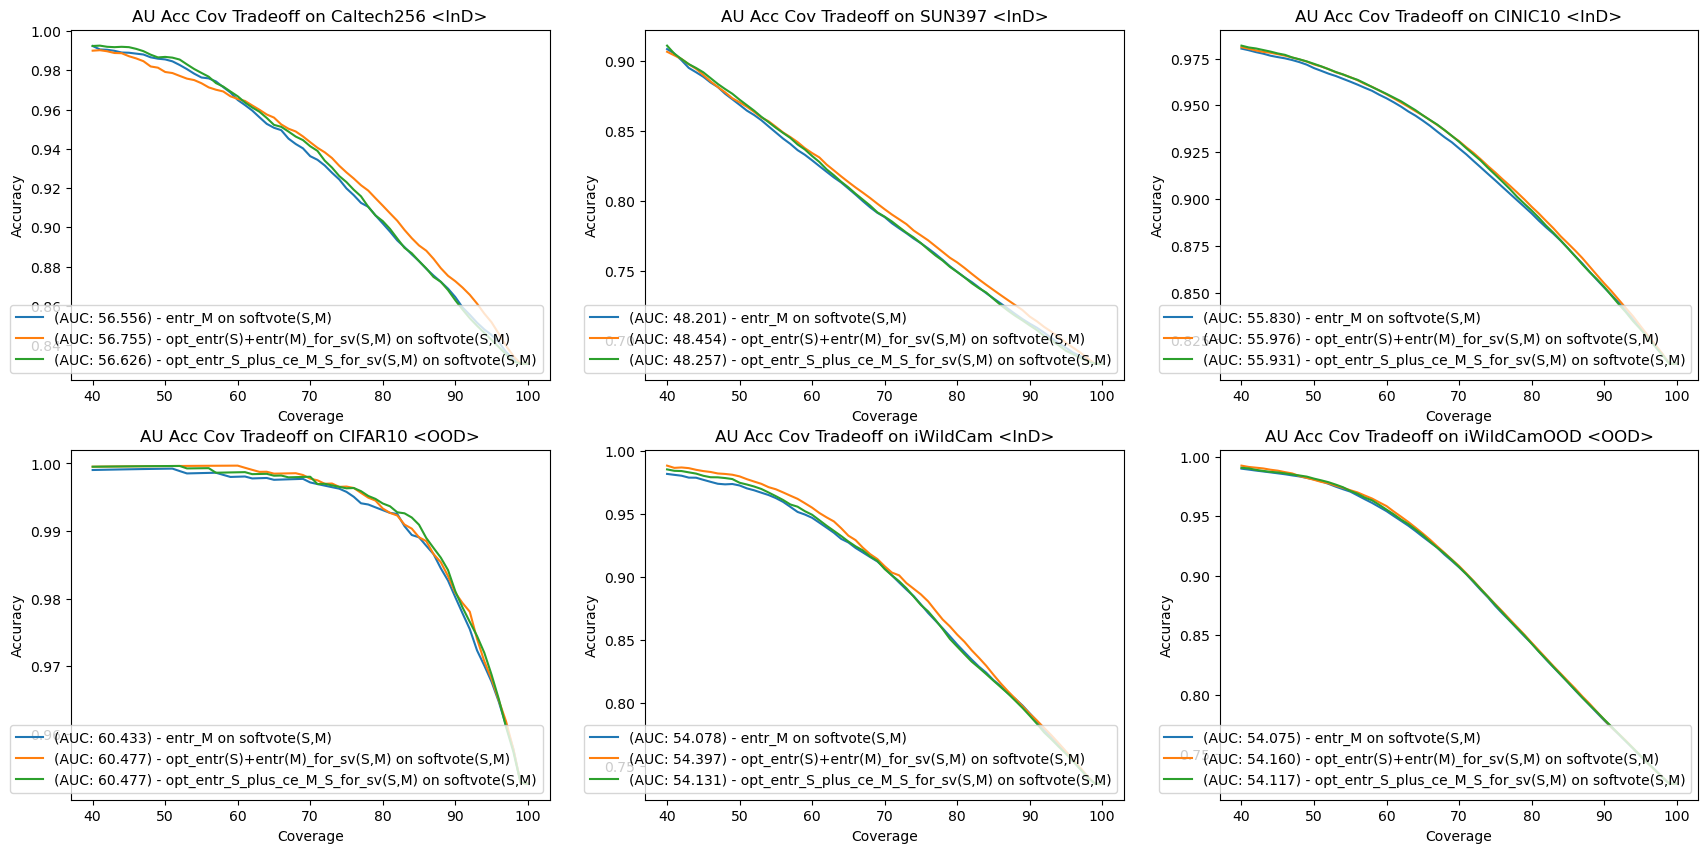

In [129]:
cov_range = np.arange(40,101)
fig, axes = plt.subplots(nrow, ncol, figsize=(7*ncol, 5*nrow))
for i, ds in enumerate(datasets):
    ax = axes[i // ncol, i % ncol]
    ax.set_title(f"AU Acc Cov Tradeoff on {ds} <{test_dypes[i]}>")
    pred = pd.read_csv(f"{pred_out_prefix}{ds}_{modelArch}.csv", index_col="Unnamed: 0")
    unc_pred = pd.read_csv(f"{unc_out_prefix}{ds}_{modelArch}.csv", index_col="Unnamed: 0")
    rank=get_rank(unc_pred)
    # display(pred.head())
    acc_cov_tradeoff(pred, "softvote(S,M)", "target", "entr_M", rank, ax, cov_range)
    # acc_cov_tradeoff(pred, "softvote(S,M)", "target", "ce_M_S", rank, ax, cov_range)
    # acc_cov_tradeoff(pred, "softvote(S,M)", "target", "entr_S+entr_M", rank, ax, cov_range)
    # acc_cov_tradeoff(pred, "softvote(S,M)", "target", "entr_M+ce_M_S", rank, ax, cov_range)
    acc_cov_tradeoff(pred, "softvote(S,M)", "target", "opt_entr(S)+entr(M)_for_sv(S,M)", rank, ax, cov_range)
    acc_cov_tradeoff(pred, "softvote(S,M)", "target", "opt_entr_S_plus_ce_M_S_for_sv(S,M)", rank, ax, cov_range)